---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

{{< include overview.qmd >}} 

# Code 

In [2]:
# # ------------------------------------ IMPORTS ------------------------------------ #
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
# Read in data
df = pd.read_csv('../../data/raw-data/dc_bike_routes.csv')
df.head()

,name,distance_mi,description,terrain,traffic,scenery
0,Potomac Tour,10,D.C. - A nice short tour of the downtown water...,1,2,2
1,BWI Trail,11,Glen Burnie - Paved trail around BWI Airport,2,1,3
2,Airpark Cruise,12,Gaithersburg - Short workout route around Mont...,3,3,3
3,Seneca Valley Tour,13,Germantown - A short workout route around Grea...,3,3,2
4,For The Boyds,14,Germantown - A short workout route through Boy...,2,3,2


In [3]:
# ------------------------------------ CREATE COLUMNS ------------------------------------ #
# Normalize the mileage column
df["distance_norm"] = (df["distance_mi"] - np.mean(df["distance_mi"])) / np.std(df["distance_mi"])
# Split location from description to make its own column. All are formatted the same so we split on the first "-"
df[['location', 'description']] = df['description'].str.split("-", n=1, expand=True)
# Create dictionary of binary columns to add
# For each column we define what text to look for in the description
keywords = {
    'unpaved': 'unpaved',
    'flat': 'flat',
    'workout': 'workout',
    'park': 'park',
    'river': 'river',
    'loop': 'loop'
}
# Loop through the keywords and assign columns to the df
for col_name, keyword in keywords.items():
    # First lower case all characters, then use contains to see if the keyword appears in the string
    # Search across both the description and name column, mostly for loop as many are named with loop
    df[col_name] = df['description'].str.lower().str.contains(keyword, regex=True).astype(int) | \
        df['name'].str.lower().str.contains(keyword, regex=True).astype(int)
    
# ------------------------------------ SENTIMENT ------------------------------------ #
# Initilize a sentiment analyzer object from nltk
sia = SentimentIntensityAnalyzer()
# Use sentiment analyzer to get the polarity scores of each description
# Save the compound score for each trail as a new column
df['sentiment'] = df['description'].apply(lambda x: sia.polarity_scores(x)['compound'])

# ------------------------------------ ASSIGN STATES ------------------------------------ #
# Define regions that fall within certain sates
# After the first pass with just keywords, we researched to find which states the following regions were part off
dc_regions = ['georgetown', 'northern suburbs']
md_regions = ['greenbelt', 'gaithersburg', 'germantown', 'bethesda', 'poolesville', 'glen burnie', \
              'eastern suburbs', 'western suburbs', 'ashland', 'northern suburbs', 'northeast suburbs', \
                'cumberland']
va_regions = ['arlington', 'alexandria', 'berryville', 'mount vernon', 'western suburbs']
pa_regions = ['york']

# Similar to adding the columns above we define the states and common words that would define them
state_keywords = {
    'DC': ['dc', 'd.c.', 'washington'] + dc_regions,  
    'MD': ['md', 'maryland'] + md_regions,
    'VA': ['va', 'virginia'] + va_regions,
    'PA': ['pa', 'pennsylvania'] + pa_regions
}
# Define function to assign states to the routes
def assign_states(location):
    # make the locations lower case
    location_lower = location.lower()
    # initilize empty list to store possible states
    possible_states = []
    # iterate through the states and their keywords
    for state, keywords in state_keywords.items():
        # check if any of the keywords are in the provided location
        if any(keyword in location_lower for keyword in keywords):
            # if yes, assign the keywords state to the list of states
            possible_states.append(state)
    # Return the list of states
    return possible_states
# Use function above to assign states to each of the bike routes. 
df['state'] = df['location'].apply(assign_states)
# Turn into seperate columns
df[['state1','state2']] = pd.DataFrame(df['state'].to_list())
# fill second state column with first state if only one state
df['state2'] = df['state2'].fillna(df['state1'])

# ------------------------------------ FINALIZE ------------------------------------ #
# drop description, location, and state columns
df = df.drop(columns=['description', 'location', 'state'])
# Check for NA
df.isna().sum()
# save to CSV
df.to_csv('../../data/processed-data/dc_bike_routes.csv', index=False)
df.head()

,name,distance_mi,terrain,traffic,scenery,distance_norm,unpaved,flat,workout,park,river,loop,sentiment,state1,state2
0,Potomac Tour,10,1,2,2,-0.963394,0,0,0,0,0,0,0.4215,DC,DC
1,BWI Trail,11,2,1,3,-0.933354,0,0,0,0,0,0,0.0000,MD,MD
2,Airpark Cruise,12,3,3,3,-0.903313,1,0,1,1,0,0,0.0000,MD,MD
3,Seneca Valley Tour,13,3,3,2,-0.873273,0,0,1,1,0,0,0.6249,MD,MD
4,For The Boyds,14,2,3,2,-0.843232,1,0,1,1,0,0,0.0000,MD,MD


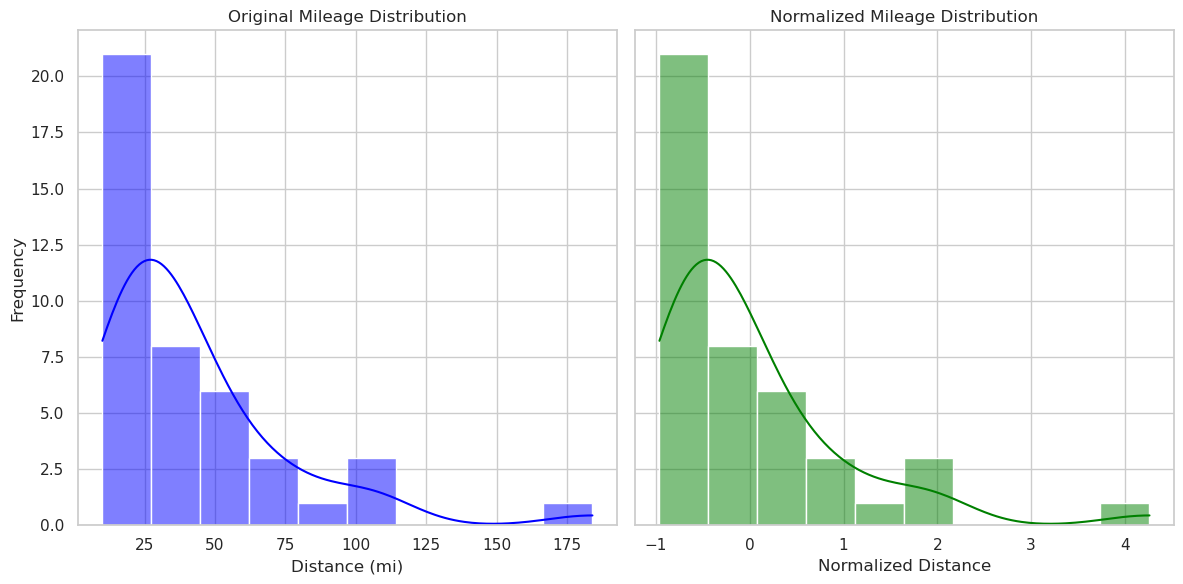

In [4]:
## Plot comparing the regular mileage distribution to the normalized one
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the original mileage distribution
sns.histplot(df["distance_mi"], kde=True, bins=10, ax=ax[0], color="blue")
ax[0].set_title("Original Mileage Distribution")
ax[0].set_xlabel("Distance (mi)")
ax[0].set_ylabel("Frequency")

# Plot the normalized mileage distribution
sns.histplot(df["distance_norm"], kde=True, bins=10, ax=ax[1], color="green")
ax[1].set_title("Normalized Mileage Distribution")
ax[1].set_xlabel("Normalized Distance")
ax[1].set_ylabel("Frequency")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()